In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

from shared.constants import STORAGE_PATH

# Load model

## Positional

In [80]:
from ml.executors import positional_executor

CKPT_POSITIONAL = STORAGE_PATH.joinpath('results/ml/positional-starwars/lightning_logs/version_0')
pos_cli = positional_executor.load_cli(
    config=str(CKPT_POSITIONAL.joinpath('config.yaml')),
    load_dir=str(CKPT_POSITIONAL)
)
data = pos_cli.dataset.data

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Loaded n_clusters=5 clusters of repr_dim=32 dimensions


/data/pella/projects/University/Thesis/Thesis/code/env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [81]:
pos_emb = pos_cli.compute_embeddings()
pos_ass = pos_cli.compute_assignments(pos_emb)
pos_emb_flat = torch.concat([pos_emb[node_type] for node_type in data.node_types], dim=0)

/data/pella/projects/University/Thesis/Thesis/code/env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `predict_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/data/pella/projects/University/Thesis/Thesis/code/env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

## Temporal

In [82]:
from ml.executors import temporal_executor

CKPT_TEMPORAL = STORAGE_PATH.joinpath('results/ml/temporal-starwars/lightning_logs/version_7')
temp_cli = temporal_executor.load_cli(
    config=str(CKPT_TEMPORAL.joinpath('config.yaml')),
        load_dir=str(CKPT_TEMPORAL)
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/pella/projects/University/Thesis/Thesis/code/env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [83]:
temp_emb = temp_cli.compute_embeddings()
temp_ass = temp_cli.compute_assignments(temp_emb)
temp_emb_flat = torch.concat([temp_emb[node_type] for node_type in data.node_types], dim=0)

/data/pella/projects/University/Thesis/Thesis/code/env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `predict_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/data/pella/projects/University/Thesis/Thesis/code/env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

# Basic Metrics

In [84]:
from ml import newman_girvan_modularity

m = newman_girvan_modularity(data, pos_ass, pos_cli.model.clustering_module.n_clusters)
print(f'Pos Modularity: {m:.4f}')

m = newman_girvan_modularity(data, temp_ass, temp_cli.model.clustering_module.n_clusters)
print(f'Temp Modularity: {m:.4f}')

Pos Modularity: 0.2587
Temp Modularity: 0.1904


In [85]:
df_types = []
for node_type in data.node_types:
    df_types.append(pd.DataFrame({
        'idx': list(range(pos_cli.dataset.data[node_type].num_nodes)),
        'type': node_type,
        'posi_cluster': pos_ass[node_type].detach().numpy(),
        'temp_cluster': temp_ass[node_type].detach().numpy(),
        'names': data[node_type].names
    }))

df = pd.concat(df_types)

<AxesSubplot:title={'center':'Temporal Cluster-Node distribution'}, ylabel='idx'>

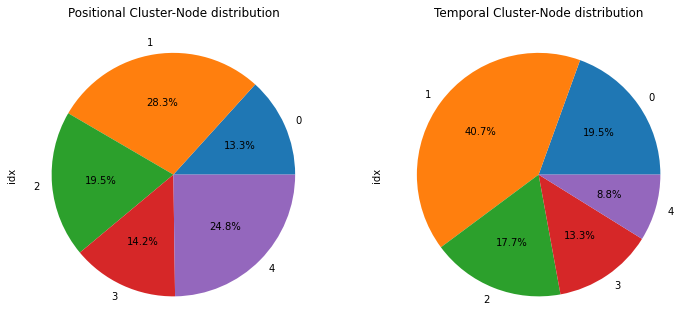

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df.groupby('posi_cluster').count().plot.pie(
    y='idx',
    ax=axes[0],
    autopct='%1.1f%%',
    legend=False,
    title='Positional Cluster-Node distribution'
)

df.groupby('temp_cluster').count().plot.pie(
    y='idx',
    ax=axes[1],
    autopct='%1.1f%%',
    legend=False,
    title='Temporal Cluster-Node distribution'
)

### Node Type Statistics

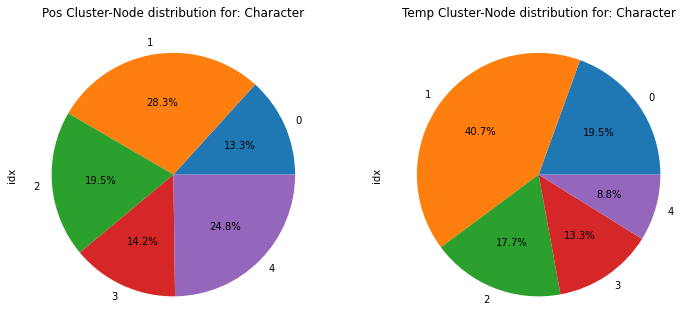

In [87]:
for node_type in data.node_types:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    df[df.type == node_type].groupby('posi_cluster').count().plot.pie(
        y='idx', ax=axes[0],
        autopct='%1.1f%%',
        legend=False,
        title=f'Pos Cluster-Node distribution for: {node_type}'
    )

    df[df.type == node_type].groupby('temp_cluster').count().plot.pie(
        y='idx', ax=axes[1],
        autopct='%1.1f%%',
        legend=False,
        title=f'Temp Cluster-Node distribution for: {node_type}'
    )

### Edge Type Statistics

## Cluster Preview

In [88]:
import faiss

In [89]:
nn_index = faiss.IndexFlatIP(pos_cli.repr_dim)
nn_index.add(pos_emb_flat.numpy())

In [90]:
K = 4
for (i, cluster) in enumerate(pos_cli.model.centroids()):
    D, I = nn_index.search(cluster.detach().unsqueeze(0).numpy(), K)
    subset = df.loc[I[0]]
    subset['sim'] = D[0]
    print(f'Top {K} Closest nodes for Community {i}')
    display(subset[['names', 'type', 'sim']])

Top 4 Closest nodes for Community 0


,names,type,sim
65,ELLO ASTY,Character,9.916223
104,YOLO ZIFF,Character,9.726691
56,NIV LEK,Character,9.726687
52,BB-8,Character,9.080132


Top 4 Closest nodes for Community 1


,names,type,sim
34,COUNT DOOKU,Character,11.339251
43,POGGLE,Character,11.181244
21,PADME,Character,10.298041
37,NUTE GUNRAY,Character,10.166844


Top 4 Closest nodes for Community 2


,names,type,sim
32,LAMA SU,Character,11.380242
111,TION MEDON,Character,10.397526
67,DOFINE,Character,10.294049
108,TEY HOW,Character,9.890406


Top 4 Closest nodes for Community 3


,names,type,sim
81,BRAVO THREE,Character,9.494700
75,BRAVO TWO,Character,9.253592
33,RUWEE,Character,8.732080
4,CAMIE,Character,8.597965


Top 4 Closest nodes for Community 4


,names,type,sim
23,ADMIRAL ACKBAR,Character,10.058316
5,HAN,Character,9.251616
0,C-3PO,Character,9.059010
26,MON MOTHMA,Character,8.756863


In [91]:
import umap
import umap.plot

Text(0.5, 1.0, 'Positional + Temporal Clusters')

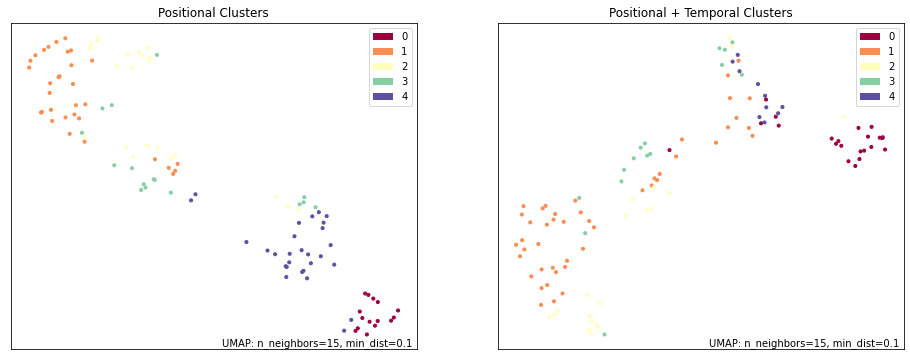

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

mapper = umap.UMAP(random_state=42).fit(pos_emb_flat.numpy())
ax = umap.plot.points(
    mapper, ax=axes[0],
    labels=df.posi_cluster,
)
ax.set_title('Positional Clusters')

mapper = umap.UMAP(random_state=42).fit(temp_emb_flat.numpy())
ax = umap.plot.points(
    mapper, ax=axes[1],
    labels=df.temp_cluster,
)
ax.set_title('Positional + Temporal Clusters')

Text(0.5, 1.0, 'Temporal Clusters / Cluster')

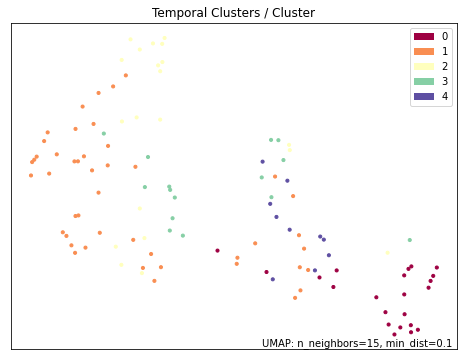

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

mapper = umap.UMAP(random_state=42).fit(temp_emb_flat[:, temp_cli.temp_dim:].numpy())
ax = umap.plot.points(
    mapper, ax=axes,
    labels=df.temp_cluster,
)
ax.set_title('Temporal Clusters / Cluster')

In [ ]:
# Visualize 2d UMAP (temporal vs timestamp)

In [ ]:
# Split graph into snapshots
# - Visualize using UMAP
# - Show relative temporal distance (norm distrib)
# - Show central nodes per cluster